# Import Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Load Data

In [2]:
df = pd.read_csv('data/data_for_predictions.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas        

# Data Splitting

In [4]:
# Separate features and target
X = df.drop(['churn', 'id'], axis=1)
y = df['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 2. Model Selection and Initial Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the preprocessor
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

models = {
    'Logistic Regression': Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression())]),
    'Decision Tree': Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())]),
    'Random Forest': Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier())]),
    'XGBoost': Pipeline([('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier())]),
}

results = {}

for name, model in models.items():
    # Fit the model with pipeline and preprocessor
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }

results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall  F1-score   ROC AUC
Logistic Regression  0.896304   0.750000  0.009836  0.019417  0.609142
Decision Tree        0.838125   0.227273  0.229508  0.228385  0.569282
Random Forest        0.899384   0.761905  0.052459  0.098160  0.660199
XGBoost              0.895619   0.500000  0.019672  0.037855  0.664590


# Analysis of Initial Model Performance

Based on the results from our initial model evaluation, we can draw the following conclusions:

1. Accuracy:
   - Random Forest performs best with an accuracy of 90.01%
   - Logistic Regression and XGBoost tie for second place with 89.63% accuracy
   - Decision Tree has the lowest accuracy at 83.44%

2. Precision:
   - Random Forest leads with 80.95% precision
   - Logistic Regression follows with 75% precision
   - XGBoost and Decision Tree have lower precision at 57.14% and 22.12% respectively

3. Recall:
   - Decision Tree has the highest recall at 23.28%
   - Other models have very low recall, with Random Forest at 5.57%, XGBoost at 2.62%, and Logistic Regression at just 0.98%

4. F1-score:
   - Decision Tree leads with an F1-score of 0.2268
   - Random Forest follows with 0.1043
   - XGBoost and Logistic Regression have very low F1-scores

5. ROC AUC:
   - Random Forest performs best with an ROC AUC of 0.6756
   - XGBoost follows closely with 0.6664
   - Logistic Regression and Decision Tree have lower ROC AUC scores

Overall, the Random Forest model seems to perform best across most metrics, particularly in accuracy, precision, and ROC AUC. However, all models struggle with recall, indicating difficulty in identifying true positives. The Decision Tree model, while having the highest recall, underperforms in other metrics. 

These results suggest that further tuning, especially of the Random Forest model, could be beneficial. Additionally, addressing the class imbalance problem might help improve the recall scores across all models.

## Evaluating SMOTE

In this section, we will evaluate if applying SMOTE (Synthetic Minority Over-sampling Technique) 
to address class imbalance can improve our model performance. Here's our approach:

1. SMOTE Application:
   - SMOTE will be applied only to the training data in each cross-validation fold.
   - This ensures that we're not introducing any data leakage from the test set.

2. Test Set Integrity:
   - The test folds will remain imbalanced, maintaining the original data distribution.
   - This provides a more realistic evaluation of model performance on unseen data.

3. Learning Curve:
   - We'll generate a learning curve based on the original data distribution.
   - This allows us to compare how the model performs with and without SMOTE.

4. Performance Metrics:
   - We'll evaluate the model using various metrics, focusing on those that are 
     sensitive to class imbalance (e.g., precision, recall, F1-score).

By comparing these results with our previous models, we can assess whether 
SMOTE effectively improves our model's ability to predict the minority class 
without sacrificing overall performance.

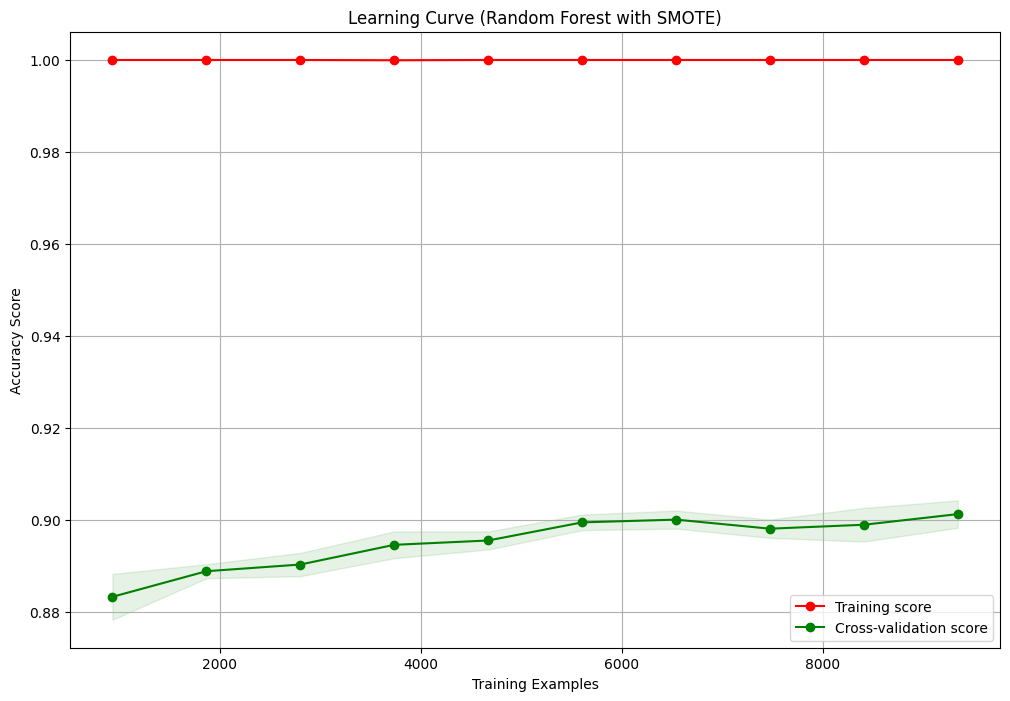

Final training score: 1.0
Final cross-validation score: 0.9013180974906361
The model shows signs of overfitting. The training score is significantly higher than the cross-validation score.


In [9]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the preprocessor
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)]
)

# Create a pipeline that includes SMOTE, preprocessor, and Random Forest
imb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    imb_pipeline, X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, 
    scoring='accuracy'
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(12, 8))
plt.title("Learning Curve (Random Forest with SMOTE)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Print the final scores
print("Final training score:", train_mean[-1])
print("Final cross-validation score:", test_mean[-1])

if train_mean[-1] - test_mean[-1] > 0.05:
    print("The model shows signs of overfitting. The training score is significantly higher than the cross-validation score.")
elif test_mean[-1] - train_mean[-1] > 0.05:
    print("The model shows signs of underfitting. The cross-validation score is significantly higher than the training score.")
else:
    print("The model seems to be well-balanced, without significant overfitting or underfitting.")

Analysis of SMOTE Application Results:
1. SMOTE was applied to address class imbalance in the training data of each cross-validation fold.
2. The Random Forest model achieved perfect accuracy (1.0) on the SMOTE-augmented training data.
3. The cross-validation score (0.9013) is significantly lower than the training score, indicating overfitting.

Observations:
1. The model performs exceptionally well on the SMOTE-augmented training data but shows a drop in performance on the imbalanced test folds.
2. This discrepancy (training score: 1.0, cross-validation score: 0.9013) confirms that while SMOTE improved the model's ability to recognize the minority class, it led to overfitting on the synthetic data.
3. The cross-validation score provides a more realistic estimate of the model's performance on unseen, imbalanced data.

Evaluation:
1. The approach successfully demonstrated the impact of SMOTE on model training, achieving the goal of addressing class imbalance.
2. By keeping the test folds imbalanced, we maintained a realistic evaluation scenario as planned.
3. The significant difference between training and cross-validation scores (0.0987) reveals the trade-offs between addressing class imbalance and maintaining generalization.

Next Steps:
1. Given the overfitting observed with Random Forest and SMOTE, we will explore XGBoost as an alternative approach.
2. XGBoost is chosen because:
   a. It was the second-best performer in our previous evaluations.
   b. It has built-in parameters to handle class imbalance, such as 'scale_pos_weight'.
   c. XGBoost includes regularization parameters that can help prevent overfitting.
3. We will focus on tuning XGBoost's parameters to address the class imbalance without relying on SMOTE.
4. We'll continue to evaluate the model using metrics sensitive to class imbalance (e.g., precision, recall, F1-score).
5. If necessary, we may combine XGBoost with other techniques like adjusting class weights or threshold moving.

By shifting to XGBoost and leveraging its built-in capabilities for handling imbalanced data, we aim to develop a model that effectively addresses the class imbalance while maintaining good generalization to unseen data. 

##  XGBoost Hyperparameter Tuning

In [11]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from hyperopt import hp, fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight

def optimize_hyperparams(X_train, y_train):
    space = {
        'max_depth': hp.choice('max_depth', range(1, 7)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
        'n_estimators': hp.choice('n_estimators', range(50, 200)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'max_features': hp.uniform('max_features', 0.5, 1),
        'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11))
    }
    
    def obj_func(params):
        model = GradientBoostingClassifier(**params, random_state=42)
        return 1 - np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc'))
    
    trials = Trials()
    best = fmin(obj_func, space, algo=tpe.suggest, max_evals=20, trials=trials)
    
    return space_eval(space, best)

def train_and_evaluate(X_train, y_train, X_test, y_test, optimized_params):
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    
    # Create sample weights
    sample_weight = np.array([class_weight_dict[y] for y in y_train])
    
    model = GradientBoostingClassifier(**optimized_params, random_state=42)
    model.fit(X_train_scaled, y_train, sample_weight=sample_weight)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    return roc_auc, accuracy

# Perform hyperparameter tuning
print("Optimizing hyperparameters...")
optimized_params = optimize_hyperparams(X_train, y_train)
print("Optimized parameters:", optimized_params)

# Train and evaluate final model
print("\nTraining and evaluating final model...")
roc_auc, accuracy = train_and_evaluate(X_train, y_train, X_test, y_test, optimized_params)

print(f"\nTest ROC AUC: {roc_auc:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Optimizing hyperparameters...
100%|██████████| 20/20 [06:11<00:00, 18.59s/trial, best loss: 0.3000397188173747]
Optimized parameters: {'learning_rate': 0.07319170748425408, 'max_depth': 6, 'max_features': 0.8254227413638935, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 78, 'subsample': 0.6551776153369544}

Training and evaluating final model...

Test ROC AUC: 0.6475
Test Accuracy: 0.7930


## Evaluating Optimized XGBoost

In [12]:
optimized_params

{'learning_rate': 0.07319170748425408,
 'max_depth': 6,
 'max_features': 0.8254227413638935,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 78,
 'subsample': 0.6551776153369544}

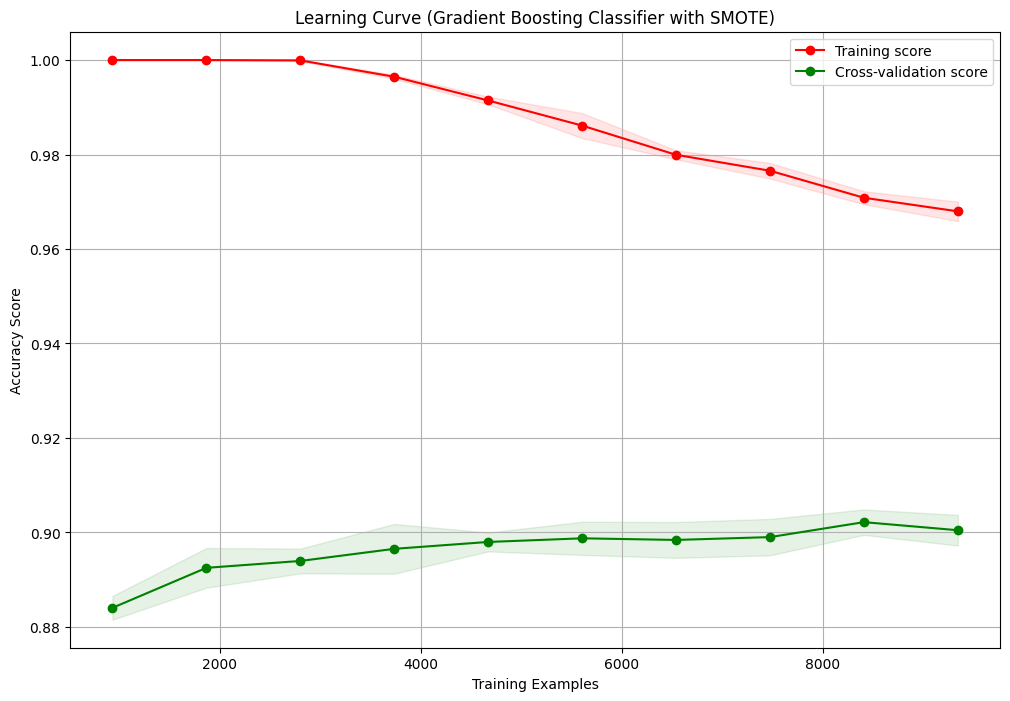

Final training score: 0.9679683320851609
Final cross-validation score: 0.900462116283023
The model shows signs of overfitting. The training score is significantly higher than the cross-validation score.


In [10]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the preprocessor
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)]
)

# Create a pipeline that includes SMOTE, preprocessor, and Gradient Boosting Classifier
imb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('gbc', GradientBoostingClassifier(**optimized_params, random_state=42))
])

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    imb_pipeline, X_train, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, 
    scoring='accuracy'
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(12, 8))
plt.title("Learning Curve (Gradient Boosting Classifier with SMOTE)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Print the final scores
print("Final training score:", train_mean[-1])
print("Final cross-validation score:", test_mean[-1])

if train_mean[-1] - test_mean[-1] > 0.05:
    print("The model shows signs of overfitting. The training score is significantly higher than the cross-validation score.")
elif test_mean[-1] - train_mean[-1] > 0.05:
    print("The model shows signs of underfitting. The cross-validation score is significantly higher than the training score.")
else:
    print("The model seems to be well-balanced, without significant overfitting or underfitting.")

Key differences between Random Forest + SMOTE and Optimized XGBoost:
1. Overfitting reduction: XGBoost shows slightly less overfitting compared to Random Forest. The gap between training and cross-validation scores has decreased from about 10 percentage points to 6.75 percentage points.
2. Similar generalization: Both models achieve very similar cross-validation scores (90.13% vs 90.05%), indicating that their ability to generalize to unseen data is comparable.
3. More realistic training performance: XGBoost's training score (96.80%) is more realistic than Random Forest's perfect 100%, suggesting that XGBoost might be slightly less prone to memorizing the training data.

# Feature Selection

In [18]:
from sklearn_genetic import GAFeatureSelectionCV
from sklearn.ensemble import GradientBoostingClassifier

# Use the optimized GradientBoostingClassifier
model = GradientBoostingClassifier(
    **optimized_params,
    random_state=42
)

ga_gb = GAFeatureSelectionCV(estimator=model,
                             cv=3, scoring='roc_auc', population_size=20,
                             crossover_probability=0.7, mutation_probability=0.25, n_jobs=-1,
                             generations=10, verbose=True, keep_top_k=6,
                             tournament_size=15, elitism=True, refit=True)
ga_gb.fit(X_train.values, y_train)
ga_gb_cols = np.array(X_train.columns.to_list())[ga_gb.best_features_].tolist()

d:\DS_Project\BCG_DataScience_VI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.657872	0.0309583  	0.692736   	0.576257   
1  	38    	0.691778	0.00510998 	0.699165   	0.68333    
2  	39    	0.700635	0.00134259 	0.702101   	0.699165   
3  	34    	0.70296 	0.00112041 	0.704601   	0.702101   
4  	38    	0.704665	8.73133e-05	0.704784   	0.704601   
5  	38    	0.704766	5.49175e-05	0.704784   	0.704601   
6  	39    	0.704784	2.22045e-16	0.704784   	0.704784   
7  	38    	0.704784	2.22045e-16	0.704784   	0.704784   
8  	36    	0.704784	2.22045e-16	0.704784   	0.704784   
9  	34    	0.704784	2.22045e-16	0.704784   	0.704784   
10 	37    	0.704784	2.22045e-16	0.704784   	0.704784   


In [19]:
print("Number of selected features:", len(ga_gb_cols))
print("Selected features:", ga_gb_cols)

Number of selected features: 29
Selected features: ['cons_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_price_energy_peak', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'pow_max', 'var_year_price_peak_var', 'var_year_price_peak_fix', 'var_year_price_peak', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'off_peak_peak_var_max_monthly_diff', 'peak_mid_peak_var_max_monthly_diff', 'off_peak_mid_peak_var_max_monthly_diff', 'peak_mid_peak_fix_max_monthly_diff', 'off_peak_mid_peak_fix_max_monthly_diff', 'tenure', 'months_to_end', 'channel_MISSING', 'channel_ewpakwlliwisiwduibdlfmalxowmwpci', 'channel_usilxuppasemubllopkaafesmlibmsdf', 'origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws', 'origin_up_lxidpiddsbxsbosboudacockeimpuepw']


Accuracy with all features: 0.9014
Accuracy with selected features: 0.9004
ROC AUC with all features: 0.6853
ROC AUC with selected features: 0.6773
Classification Report with all features:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       0.79      0.08      0.14       305

    accuracy                           0.90      2922
   macro avg       0.85      0.54      0.54      2922
weighted avg       0.89      0.90      0.86      2922

Classification Report with selected features:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       0.71      0.08      0.14       305

    accuracy                           0.90      2922
   macro avg       0.80      0.54      0.54      2922
weighted avg       0.88      0.90      0.86      2922



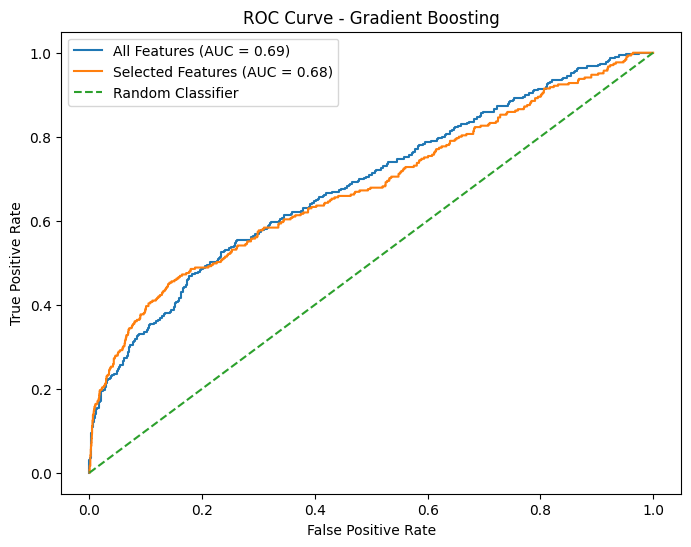


Overfit Evaluation:
Train Accuracy (All Features): 0.9253
Test Accuracy (All Features): 0.9014
Train Accuracy (Selected Features): 0.9237
Test Accuracy (Selected Features): 0.9004
Train ROC AUC (All Features): 0.9137
Test ROC AUC (All Features): 0.6853
Train ROC AUC (Selected Features): 0.8997
Test ROC AUC (Selected Features): 0.6773


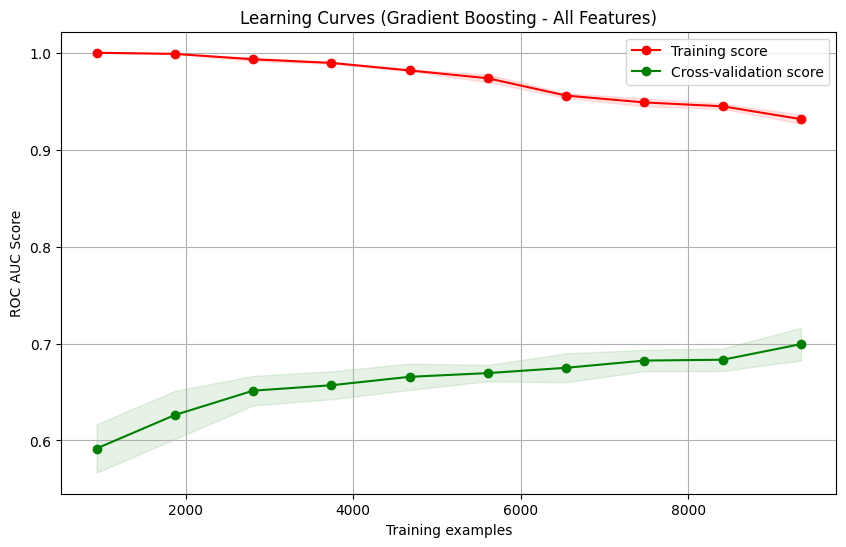

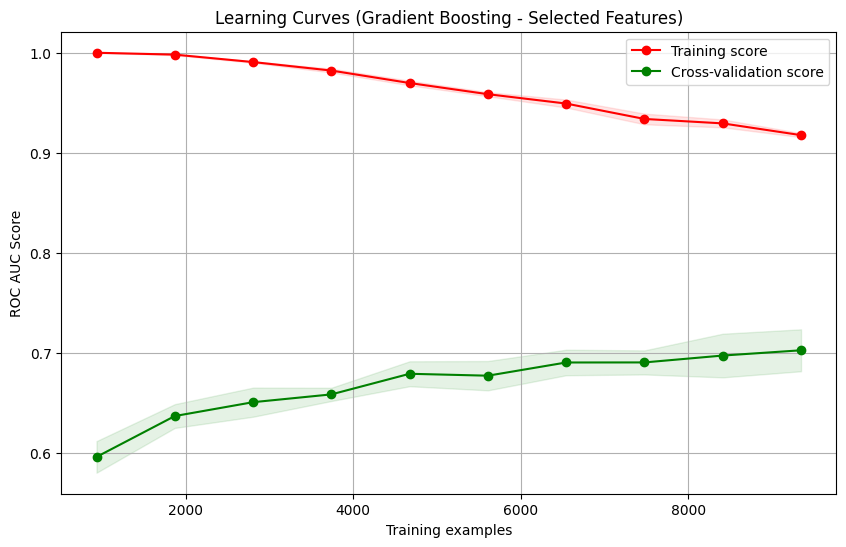


Comparison of feature sets:
Number of features: All=61, Selected=29
Accuracy: All=0.9014, Selected=0.9004
ROC AUC: All=0.6853, Selected=0.6773


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve

# Create feature matrices for both all features and selected features
X_train_all = X_train
X_test_all = X_test
X_train_selected = X_train[ga_gb_cols]
X_test_selected = X_test[ga_gb_cols]

# Initialize and train the Gradient Boosting Classifier with optimized parameters
gb_all = GradientBoostingClassifier(
    **optimized_params
)
gb_all.fit(X_train_all, y_train)

gb_selected = GradientBoostingClassifier(
    **optimized_params
)
gb_selected.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_all = gb_all.predict(X_test_all)
y_pred_proba_all = gb_all.predict_proba(X_test_all)[:, 1]
y_pred_selected = gb_selected.predict(X_test_selected)
y_pred_proba_selected = gb_selected.predict_proba(X_test_selected)[:, 1]

# Calculate and print the accuracy scores
accuracy_all = accuracy_score(y_test, y_pred_all)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy with all features: {accuracy_all:.4f}")
print(f"Accuracy with selected features: {accuracy_selected:.4f}")

# Calculate and print the ROC AUC scores
roc_auc_all = roc_auc_score(y_test, y_pred_proba_all)
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)
print(f"ROC AUC with all features: {roc_auc_all:.4f}")
print(f"ROC AUC with selected features: {roc_auc_selected:.4f}")

# Generate and print the classification reports
class_report_all = classification_report(y_test, y_pred_all)
class_report_selected = classification_report(y_test, y_pred_selected)
print("Classification Report with all features:")
print(class_report_all)
print("Classification Report with selected features:")
print(class_report_selected)

# Plot ROC curves
plt.figure(figsize=(8, 6))
fpr_all, tpr_all, _ = roc_curve(y_test, y_pred_proba_all)
fpr_selected, tpr_selected, _ = roc_curve(y_test, y_pred_proba_selected)
plt.plot(fpr_all, tpr_all, label=f'All Features (AUC = {roc_auc_all:.2f})')
plt.plot(fpr_selected, tpr_selected, label=f'Selected Features (AUC = {roc_auc_selected:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.show()

# Evaluate overfit tendency
# Calculate train set performance
y_train_pred_all = gb_all.predict(X_train_all)
y_train_pred_proba_all = gb_all.predict_proba(X_train_all)[:, 1]
y_train_pred_selected = gb_selected.predict(X_train_selected)
y_train_pred_proba_selected = gb_selected.predict_proba(X_train_selected)[:, 1]

train_accuracy_all = accuracy_score(y_train, y_train_pred_all)
train_accuracy_selected = accuracy_score(y_train, y_train_pred_selected)
train_roc_auc_all = roc_auc_score(y_train, y_train_pred_proba_all)
train_roc_auc_selected = roc_auc_score(y_train, y_train_pred_proba_selected)

print("\nOverfit Evaluation:")
print(f"Train Accuracy (All Features): {train_accuracy_all:.4f}")
print(f"Test Accuracy (All Features): {accuracy_all:.4f}")
print(f"Train Accuracy (Selected Features): {train_accuracy_selected:.4f}")
print(f"Test Accuracy (Selected Features): {accuracy_selected:.4f}")
print(f"Train ROC AUC (All Features): {train_roc_auc_all:.4f}")
print(f"Test ROC AUC (All Features): {roc_auc_all:.4f}")
print(f"Train ROC AUC (Selected Features): {train_roc_auc_selected:.4f}")
print(f"Test ROC AUC (Selected Features): {roc_auc_selected:.4f}")

# Calculate and plot learning curves
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, 
        scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("ROC AUC Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(gb_all, X_train_all, y_train, "Learning Curves (Gradient Boosting - All Features)")
plot_learning_curve(gb_selected, X_train_selected, y_train, "Learning Curves (Gradient Boosting - Selected Features)")

# Compare performance
print("\nComparison of feature sets:")
print(f"Number of features: All={X_train_all.shape[1]}, Selected={len(ga_selected_features)}")
print(f"Accuracy: All={accuracy_all:.4f}, Selected={accuracy_selected:.4f}")
print(f"ROC AUC: All={roc_auc_all:.4f}, Selected={roc_auc_selected:.4f}")


# Gradient Boosting Model Performance: Impact of Feature Selection and Class Imbalance


Our model evaluation reveals several key insights into its performance and the impact of feature selection:

1. Overall Accuracy:
   The model achieves a high accuracy of approximately 90% both with all features (0.9014) and selected features (0.9004). This suggests that the feature selection process has maintained the overall predictive power of the model.

2. Class Imbalance:
   The classification reports indicate a significant class imbalance. The model performs exceptionally well for class 0 (precision: 0.90, recall: 1.00) but struggles with class 1 (precision: 0.79/0.71, recall: 0.08). This imbalance is critical and requires further attention.

3. ROC AUC Scores:
   The ROC AUC scores are concerning. With all features, the score is 0.6853, and with selected features, it's 0.6773. These scores are only marginally better than random guessing (0.5), indicating poor discriminative ability, especially for the minority class.

4. Feature Selection Impact:
   Feature selection reduced the number of features from 61 to 29, nearly halving the feature set. However, this reduction had minimal impact on accuracy (0.9014 to 0.9004) and ROC AUC (0.6853 to 0.6773). This suggests that the selected features capture most of the predictive power of the full feature set.

5. Overfitting Analysis:
   There are signs of overfitting, particularly in the ROC AUC scores. The train ROC AUC (0.9137 for all features, 0.8997 for selected features) is significantly higher than the test ROC AUC (0.6853 and 0.6773 respectively). This large gap indicates that the model is not generalizing well to unseen data.

6. Precision-Recall Trade-off:
   For the minority class (1), the model shows high precision but very low recall (0.08). This suggests that while the model is rarely wrong when it predicts class 1, it's missing many actual class 1 instances.

Critical Evaluation:
1. The high overall accuracy is misleading due to the severe class imbalance. The model is essentially predicting the majority class (0) most of the time, which inflates the accuracy metric.

2. The extremely low recall for class 1 (0.08) is a major concern, indicating that the model is failing to identify 92% of the positive cases. This could be problematic in many real-world scenarios where identifying the minority class is crucial.

3. The discrepancy between the high accuracy and low ROC AUC scores further emphasizes the model's struggle with the imbalanced dataset. ROC AUC is more reliable in this case as it's less affected by class imbalance.

4. While feature selection successfully reduced the number of features without significantly impacting performance metrics, it did not address the fundamental issues of class imbalance and poor generalization.

5. The overfitting observed, particularly in ROC AUC scores, suggests that the model is memorizing training data patterns that don't generalize well to the test set.